# EEG-based BCI using Visual Imagery and Emotiv Epoc X:  An Exploratory Study

## Computational Cognitive Neuroscience 2020/2021

### Decoding analysis using time-frequency features with SVM, LR, LDA, RF

### In this notebook, features from all 14-channels are taken into account

### Import Libraries

In [1]:
%%capture libraries   

import sys
import os
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install mne
!{sys.executable} -m pip install mne-features
import numpy as np
import matplotlib 
import pathlib
import mne
import seaborn as sns
import pandas as pd
from mne.io import concatenate_raws, read_raw_edf
from mne import Epochs, create_info, events_from_annotations
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs,corrmap
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch, tfr_stockwell,tfr_multitaper,tfr_array_morlet,AverageTFR
from scipy import signal
from scipy.integrate import simps
matplotlib.use('Qt5Agg') #allow interactive plots
import matplotlib.pyplot as plt
from mne.decoding import GeneralizingEstimator, Scaler,cross_val_multiscore, LinearModel, get_coef, Vectorizer, CSP, SlidingEstimator
from mne.viz import centers_to_edges
from mne.baseline import rescale
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold, ShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support, precision_recall_curve, average_precision_score, plot_precision_recall_curve, ConfusionMatrixDisplay, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import plot_roc_curve, accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
%SM1.ipynb import load_data, excl_chan, filter_data, make_epochs, plot_data, epochs_power

### Load the cleaned epoched dataset

In [2]:
epochs_all= mne.read_epochs('epoched_data_280-epo.fif', preload=True) #data from all channels

Reading epoched_data_280-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    9746.09 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated


In [3]:
#check the shape, it should be (280,14,2432) n_epochs, n_channels, n_timepoints because we are considering all the channels
print(epochs_all.get_data().shape)  

(280, 14, 2432)


#### Equalize the number of epochs count in each condition 



In [4]:
mne.Epochs.equalize_event_counts(epochs_all, event_ids=epochs_all.event_id)
print(type(epochs_all)) #double-check it's EpochsFIF
print(epochs_all.get_data().shape)

Dropped 4 epochs: 132, 167, 204, 271
<class 'mne.epochs.EpochsFIF'>
(276, 14, 2432)


### Firstly, compute Time-Frequency Analysis (TFR) using Morlet Wavelet Transfom:

In [5]:
freqs = np.logspace(*np.log10([2, 30]), num=40) # define frequencies of interest (log-spaced) 
n_cycles = freqs / 2.  # different number of cycle per frequency

power_all = mne.time_frequency.tfr_morlet(epochs_all, freqs=freqs, n_cycles=n_cycles, use_fft=True, average=False,
                                           return_itc=False, decim=3, n_jobs=1)  
 
print(power_all.data.shape)

Not setting metadata
(276, 14, 40, 811)


In [7]:
#Extract TFR features in Theta band (4-7Hz)

n_col= power_all.data.shape[3] #extract n columns from power_all
n_chan=power_all.data.shape[1] #extract n channels
n_row= power_all.data.shape[0] #extract n rows


theta_pow_all = np.zeros(shape=(n_row,n_chan,n_col))  
counter=0
for samples in range (0,n_row):
    for chan in range(0, n_chan):
        pow_t = power_all.data[samples][chan][(power_all.freqs>=4) & (power_all.freqs<7)][:]  
        counter+=1
        pow_avg_t = np.mean(pow_t, axis=0) 
        theta_pow_all[samples,chan,:]=pow_avg_t
        

In [36]:
#Extract TFR features in Alpha band (8-12Hz)

n_col= power_all.data.shape[3] #extract n columns from pw output
n_chan=power_all.data.shape[1] #extract n channels
n_row= power_all.data.shape[0] #extract n rows

alpha_pow_all = np.zeros(shape=(n_row,n_chan,n_col))   
counter=0
for samples in range (0,n_row):
    for chan in range(0, n_chan): 
        pow_a = power_all.data[samples][chan][(power_all.freqs>=8) & (power_all.freqs<12)][:]  
        counter+=1
        pow_avg_a = np.mean(pow_a, axis=0)  
        alpha_pow_all[samples,chan,:]=pow_avg_a

In [66]:
#Extract TFR features in Beta band (13-30Hz)

n_col= power_all.data.shape[3] #extract n columns from pw output
n_chan=power_all.data.shape[1] #extract n channels
n_row= power_all.data.shape[0] #extract n rows

beta_pow_all = np.zeros(shape=(n_row,n_chan,n_col))    
counter=0
for samples in range (0,n_row):
    for chan in range(0, n_chan): 
        pow_b = power_all.data[samples][chan][(power_all.freqs>=13) & (power_all.freqs<30)][:]  
        counter+=1
        pow_avg_b = np.mean(pow_b, axis=0)  
        beta_pow_all[samples,chan,:]=pow_avg_b

### Prepare the dataset to fed into the classifiers:



Firstly, initialise the below variables to store the accuracies from all classifiers:

In [8]:
accuracies, f1_scores = [], [] #run this cell only once

In [68]:
#Uncomment the dataset to use

#data=theta_pow_all
#data=alpha_pow_all
data= beta_pow_all   

labels = epochs_all.events[:,-1] #our labels

In [39]:
#Double-check the shape 

print(np.shape(data))
print(np.shape(labels))

(276, 14, 811)
(276,)


 Split the dataset into training and testing with a 70:30 ratio (Training:Test):


In [70]:
#specifiy a random state to replicate the result

train_data, test_data, labels_train, labels_test = train_test_split(data, labels, test_size=0.30, random_state=93) 


### Define the Support Vector Machine(SVM)

In [71]:
clf_svm_pip = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(probability=True))  #define pipeline
parameters = {'svc__kernel':['linear','rbf', 'sigmoid'], 'svc__C':[0.1, 1, 10], 'svc__gamma':[0.1,0.01,0.001]}
#Apply GridSearchCV to identify the best parameters
gs_cv_svm = GridSearchCV(clf_svm_pip, parameters, scoring='accuracy', cv=StratifiedKFold(n_splits=10), return_train_score=True) 

#Training is done by passing the training data and their labels to fit() function.

gs_cv_svm.fit(train_data, labels_train)
print('Best Parameters: {}'.format(gs_cv_svm.best_params_))
print('Best Score: {}'.format(gs_cv_svm.best_score_))


predictions_svm = gs_cv_svm.predict(test_data)

#Evaluate
report_svm = classification_report(labels_test, predictions_svm, target_names=['Relax', 'Push'])
print('SVM Clasification Report:\n {}'.format(report_svm))

acc_svm = accuracy_score(labels_test, predictions_svm)
print("Accuracy of SVM model: {}".format(acc_svm))

precision_svm,recall_svm,fscore_svm,support_svm=precision_recall_fscore_support(labels_test,predictions_svm,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_svm,recall_svm,fscore_svm))

Best Parameters: {'svc__C': 0.1, 'svc__gamma': 0.01, 'svc__kernel': 'sigmoid'}
Best Score: 0.553421052631579
SVM Clasification Report:
               precision    recall  f1-score   support

       Relax       0.55      0.60      0.57        40
        Push       0.59      0.53      0.56        43

    accuracy                           0.57        83
   macro avg       0.57      0.57      0.57        83
weighted avg       0.57      0.57      0.57        83

Accuracy of SVM model: 0.5662650602409639
Precision: 0.5675990675990676, Recall: 0.5674418604651162, f1-score:0.5662020905923344


In [72]:
#Area Under Curve (AUC) value
auc = roc_auc_score(labels_test, predictions_svm)
print('ROC AUC: %f' % auc)

ROC AUC: 0.567442


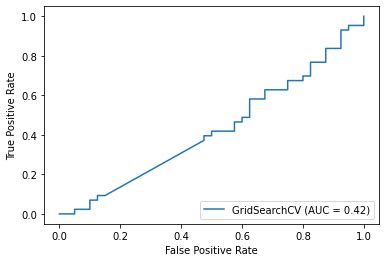

In [73]:
#ROC result
svm_roc = plot_roc_curve(gs_cv_svm, test_data, labels_test)  

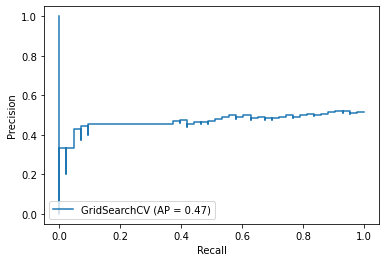

In [74]:
#Precision-Recall result
svm_pr = plot_precision_recall_curve(gs_cv_svm, test_data, labels_test) #precision-recall curve

In [75]:
# Performance metrics
errors_svc = abs(predictions_svm - labels_test)
print('Average absolute error:', round(np.mean(errors_svc), 2), 'degrees.')

Average absolute error: 0.43 degrees.


### Linear Discriminant Analysis (LDA)

In [76]:
clf_lda_pip = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis())
parameters = {'lineardiscriminantanalysis__solver':['svd']}
gs_cv_lda = GridSearchCV(clf_lda_pip, parameters, scoring='accuracy', cv=StratifiedKFold(n_splits=10), return_train_score=True) 
gs_cv_lda.fit(train_data,labels_train)
 
print('Best Parameters: {}'.format(gs_cv_lda.best_params_))
print('Best Score: {}'.format(gs_cv_lda.best_score_))


#Predictions
predictions_lda = gs_cv_lda.predict(test_data)

#Evaluation
report_lda = classification_report(labels_test, predictions_lda, target_names=['Relax', 'Push'])
print('LDA Clasification Report:\n {}'.format(report_lda))

acc_lda = accuracy_score(labels_test, predictions_lda)
print("Accuracy of LDA model: {}".format(acc_lda))

precision_lda,recall_lda,fscore_lda,support_lda=precision_recall_fscore_support(labels_test,predictions_lda,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_lda,recall_lda,fscore_lda))

Best Parameters: {'lineardiscriminantanalysis__solver': 'svd'}
Best Score: 0.5584210526315789
LDA Clasification Report:
               precision    recall  f1-score   support

       Relax       0.57      0.50      0.53        40
        Push       0.58      0.65      0.62        43

    accuracy                           0.58        83
   macro avg       0.58      0.58      0.57        83
weighted avg       0.58      0.58      0.58        83

Accuracy of LDA model: 0.5783132530120482
Precision: 0.5773809523809523, Recall: 0.5755813953488372, f1-score:0.5743589743589744


In [77]:
#Area Under Curve (AUC) value
auc = roc_auc_score(labels_test, predictions_lda)
print('ROC AUC: %f' % auc)

ROC AUC: 0.575581


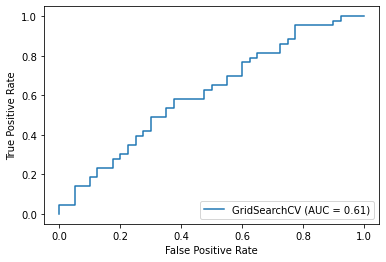

In [78]:
#ROC 
lda_roc = plot_roc_curve(gs_cv_lda, test_data, labels_test) 

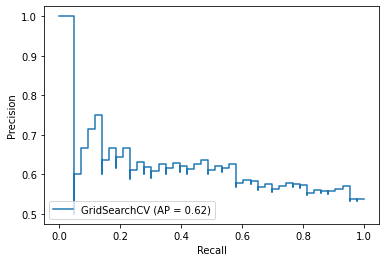

In [79]:
#Precision-Recall 
lda_pr = plot_precision_recall_curve(gs_cv_lda,test_data, labels_test)  

In [80]:
# Performance metrics
errors_lda = abs(predictions_lda - labels_test)
print('Average absolute error:', round(np.mean(errors_lda), 2), 'degrees.')

Average absolute error: 0.42 degrees.


### Logistic Regression (LR)

In [81]:
clf_lr_pip = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(max_iter=5000))
parameters ={'logisticregression__C': np.logspace(0, 4, 100)}  


gs_cv_lr = GridSearchCV(clf_lr_pip, parameters, scoring='accuracy', cv=StratifiedKFold(n_splits=10))
gs_cv_lr.fit(train_data, labels_train)

print('Best Parameters: {}'.format(gs_cv_lr.best_params_))
print('Best Score: {}'.format(gs_cv_lr.best_score_))

#Predictions
predictions_lr = gs_cv_lr.predict(test_data)

#Evaluation
report_lr = classification_report(labels_test, predictions_lr, target_names=['Relax', 'Push'])
print('LR Clasification Report:\n {}'.format(report_lr))

acc_lr = accuracy_score(labels_test, predictions_lr)
print("Accuracy of LR model: {}".format(acc_lr))

precision_lr,recall_lr,fscore_lr,support_lr=precision_recall_fscore_support(labels_test,predictions_lr,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_lr,recall_lr,fscore_lr))

Best Parameters: {'logisticregression__C': 464.1588833612782}
Best Score: 0.5171052631578947
LR Clasification Report:
               precision    recall  f1-score   support

       Relax       0.56      0.47      0.51        40
        Push       0.57      0.65      0.61        43

    accuracy                           0.57        83
   macro avg       0.57      0.56      0.56        83
weighted avg       0.57      0.57      0.56        83

Accuracy of LR model: 0.5662650602409639
Precision: 0.5651260504201681, Recall: 0.5630813953488372, f1-score:0.5611045828437133


In [82]:
#Area Under Curve (AUC) value
auc = roc_auc_score(labels_test, predictions_lr)
print('ROC AUC: %f' % auc)

ROC AUC: 0.563081


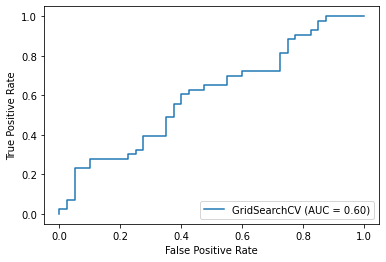

In [83]:
#ROC
lr_roc = plot_roc_curve(gs_cv_lr, test_data, labels_test)  

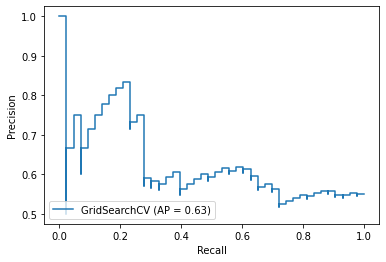

In [84]:
#Precision
lr_pr = plot_precision_recall_curve(gs_cv_lr, test_data, labels_test)  

In [85]:
# Performance metrics
errors_lr = abs(predictions_lr - labels_test)
print('Average absolute error:', round(np.mean(errors_lr), 2), 'degrees.')

Average absolute error: 0.43 degrees.


### Random Forest (RF)

In [86]:
clf_rf_pip = make_pipeline(Vectorizer(), StandardScaler(), RandomForestClassifier()) 
parameters = {'randomforestclassifier__n_estimators':[100,200,300,400,500,600,700], 'randomforestclassifier__criterion':['gini','entropy'], 'randomforestclassifier__max_depth':[1,2,3,4,5]} 
gs_cv_rf = GridSearchCV(clf_rf_pip, parameters, scoring='accuracy', cv=StratifiedKFold(n_splits=10), return_train_score=True)  
gs_cv_rf.fit(train_data,labels_train)

print('Best Parameters: {}'.format(gs_cv_rf.best_params_))
print('Best Score: {}'.format(gs_cv_rf.best_score_))

predictions_rf = gs_cv_rf.predict(test_data)

#Evaluation
report_rf = classification_report(labels_test, predictions_rf, target_names=['Relax', 'Push'])
print('RF Clasification Report:\n {}'.format(report_rf))

acc_rf = accuracy_score(labels_test, predictions_rf)
print("Accuracy of RF model: {}".format(acc_rf))

precision_rf,recall_rf,fscore_rf,support_rf=precision_recall_fscore_support(labels_test,predictions_rf,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_rf,recall_rf,fscore_rf))

Best Parameters: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 1, 'randomforestclassifier__n_estimators': 600}
Best Score: 0.605263157894737
RF Clasification Report:
               precision    recall  f1-score   support

       Relax       0.55      0.70      0.62        40
        Push       0.62      0.47      0.53        43

    accuracy                           0.58        83
   macro avg       0.59      0.58      0.57        83
weighted avg       0.59      0.58      0.57        83

Accuracy of RF model: 0.5783132530120482
Precision: 0.5870098039215687, Recall: 0.5825581395348837, f1-score:0.5743589743589744


In [87]:
#Area Under Curve (AUC) value
auc = roc_auc_score(labels_test, predictions_rf)
print('ROC AUC: %f' % auc)

ROC AUC: 0.582558


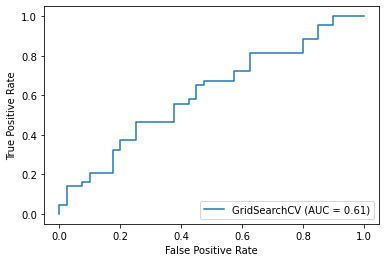

In [88]:
#ROC
rf_roc = plot_roc_curve(gs_cv_rf, test_data, labels_test) 

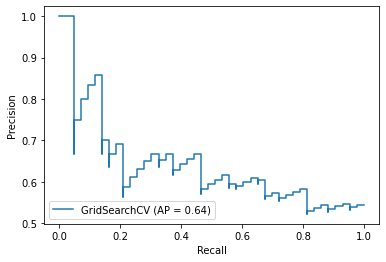

In [89]:
#Precision
rf_pr = plot_precision_recall_curve(gs_cv_rf, test_data, labels_test)  

In [90]:
# Performance metrics
errors_rf = abs(predictions_rf - labels_test)
print('Average absolute error:', round(np.mean(errors_rf), 2), 'degrees.')

Average absolute error: 0.42 degrees.


Store the classifier performance:

In [91]:
accuracies.append([acc_svm, acc_lda, acc_lr, acc_rf])
f1_scores.append([fscore_svm, fscore_lda,  fscore_lr, fscore_rf ])

### ROC Curve comparison


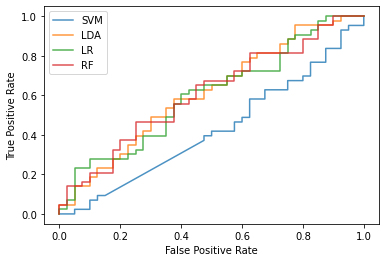

In [92]:
%matplotlib inline

ax = plt.gca()

svm_roc.plot(ax=ax, alpha=0.8,label='SVM')
lda_roc.plot(ax=ax, alpha=0.8,label='LDA')   
lr_roc.plot(ax=ax, alpha=0.8,label='LR')        
rf_roc.plot(ax=ax, alpha=0.8,label='RF')

 
plt.legend()
plt.show()

### Precision-Recall Curve comparison


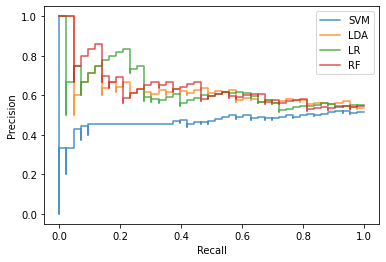

In [93]:
#%matplotlib inline

ax = plt.gca()

svm_pr.plot(ax=ax, alpha=0.8,label='SVM')
lda_pr.plot(ax=ax, alpha=0.8,label='LDA')
lr_pr.plot(ax=ax, alpha=0.8,label='LR')
rf_pr.plot(ax=ax, alpha=0.8,label='RF')

plt.legend()
plt.show()

### Compare the performance of these four different models (Accuracy & F1-score)

In [94]:
print(np.shape(accuracies)) #the final shape should be (3,4)
print(accuracies)

(3, 4)
[[0.3373493975903614, 0.6024096385542169, 0.5301204819277109, 0.5301204819277109], [0.5301204819277109, 0.5903614457831325, 0.6024096385542169, 0.5662650602409639], [0.5662650602409639, 0.5783132530120482, 0.5662650602409639, 0.5783132530120482]]


In [95]:
print(np.shape(f1_scores)) #the final shape should be (3,4)
print(f1_scores)

(3, 4)
[[0.336964415395788, 0.6024096385542168, 0.5257142857142857, 0.5290266259275425], [0.5298474945533769, 0.5874269005847954, 0.6003210272873195, 0.5646853146853146], [0.5662020905923344, 0.5743589743589744, 0.5611045828437133, 0.5743589743589744]]


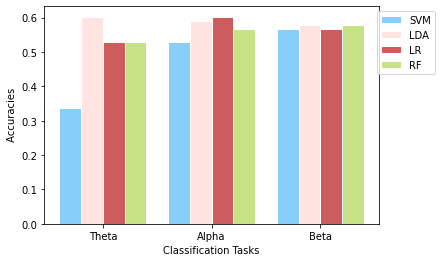

In [102]:
# Plot Accuracy scores
 
barWidth = 0.2 # Choose the height of the bars



bars1 = [row[0] for row in accuracies ]  
bars2 = [row[1] for row in accuracies ]
bars3 = [row[2] for row in accuracies ]
bars4 = [row[3] for row in accuracies ]
 


# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]


# Create the bars
ax = plt.axes()
plt.bar(r1, bars1, color='#87CEFA', width=barWidth, edgecolor='white', label='SVM')
plt.bar(r2, bars2, color='#FFE4E1', width=barWidth, edgecolor='white', label='LDA')
plt.bar(r3, bars3, color='#CD5C5C', width=barWidth, edgecolor='white', label='LR')
plt.bar(r4, bars4, color='#C5E384', width=barWidth, edgecolor='white', label='RF')

#plt.axhline(y=0.5, color='k', linestyle='--',linewidth=0.4)
#plt.axhline(y=0.6, color='r', linestyle='--',linewidth=0.4)
plt.xlabel('Classification Tasks')
plt.ylabel(' Accuracies')
ax.set_xticks([0.3,1.3,2.3])
ax.set_xticklabels(['Theta','Alpha','Beta'])
plt.legend(loc="upper left", bbox_to_anchor=(0.98, 1))

plt.show()

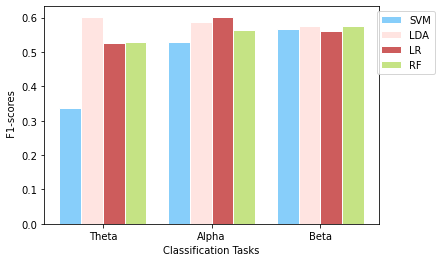

In [97]:
# Plot F1-scores
 
barWidth = 0.2 # Choose the height of the bars


bars1 = [row[0] for row in f1_scores ] 
bars2 = [row[1] for row in f1_scores ]
bars3 = [row[2] for row in f1_scores ]
bars4 = [row[3] for row in f1_scores ]
 

# The x position of bars

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]


# Create the bars
ax = plt.axes()
plt.bar(r1, bars1, color='#87CEFA', width=barWidth, edgecolor='white', label='SVM')
plt.bar(r2, bars2, color='#FFE4E1', width=barWidth, edgecolor='white', label='LDA')
plt.bar(r3, bars3, color='#CD5C5C', width=barWidth, edgecolor='white', label='LR')
plt.bar(r4, bars4, color='#C5E384', width=barWidth, edgecolor='white', label='RF')

#plt.axhline(y=0.5, color='k', linestyle='--',linewidth=0.4)
#plt.axhline(y=0.6, color='r', linestyle='--',linewidth=0.4)
plt.xlabel('Classification Tasks')
plt.ylabel(' F1-scores')
ax.set_xticks([0.3,1.3,2.3])
ax.set_xticklabels(['Theta','Alpha','Beta'])
plt.legend(loc="upper left", bbox_to_anchor=(0.98, 1))

plt.show()

### Explore the Feature Importance in RF

In [ ]:
#Define the classifier
clf_rf_pip = make_pipeline(Vectorizer(), StandardScaler(), RandomForestClassifier(n_estimators=500, max_depth=4))
clf_rf_pip.fit(train_data,labels_train)
predictions_rf = clf_rf_pip.predict(test_data)

clf_rf_pip[2].feature_importances_ #impurity-based feature importances
feature_names = [f'feature {i}' for i in range(clf_rf_pip[2].n_features_)]
#print(feature_names)
chan=epochs_all.info['ch_names']
idx = [item for item in chan for i in range(811)]
feature_imp = pd.Series(clf_rf_pip[2].feature_importances_, index=idx).sort_values(ascending=False)

In [ ]:
#Plot the features

#%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()